<a href="https://colab.research.google.com/github/21Ovi/TensorFlow_/blob/main/04_Transfer_Learning_in_TensorFlow_02_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebook, we cpvered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : 

`Fine-Tuning`,

In [1]:
# Check if we're using a GPY
!nvidia-smi

Fri Apr 14 16:34:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In Previous notebooks, we've created a bunch of helper functins, now we could rewrite them all, however, this is tedious

So, it's a good idea to put functions you'll want to use again in a script you can download and import into notebooks( or elsewhere).

we've done this for some of the previous functions we've used previously here :

 https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py

--2023-04-14 16:34:11--  https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10116 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-04-14 16:34:11 (89.3 MB/s) - ‘helper_functions.py’ saved [10116/10116]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

>**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functins.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and applyu them to our own problem (recognizing images of food):
https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-04-14 16:34:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  34.4MB/s    in 5.2s    

2023-04-14 16:34:20 (31.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Checkout how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Checkout the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[3.00000000e+00 3.00000000e+00 3.00000000e+00]
   [3.00000000e+00 3.00000000e+00 3.00000000e+00]
   [3.00000000e+00 3.00000000e+00 3.00000000e+00]
   ...
   [1.08642792e+02 6.29234123e+01 3.97091484e+01]
   [1.09000000e+02 6.40000000e+01 4.31428833e+01]
   [1.04571358e+02 6.15713577e+01 4.45713577e+01]]

  [[1.92857146e+00 1.92857146e+00 1.92857146e+00]
   [1.92857146e+00 1.92857146e+00 1.92857146e+00]
   [1.92857146e+00 1.92857146e+00 1.92857146e+00]
   ...
   [1.09499954e+02 6.42703857e+01 4.14285507e+01]
   [1.06780586e+02 6.37805862e+01 4.50612221e+01]
   [1.00714180e+02 5.76886673e+01 4.17652054e+01]]

  [[2.14285851e-01 2.14285851e-01 2.14285851e-01]
   [2.14285851e-01 2.14285851e-01 2.14285851e-01]
   [2.14285851e-01 2.14285851e-01 2.14285851e-01]
   ...
   [1.11045891e+02 6.59540634e+01 4.49999771e+01]
   [1.04943825e+02 6.19438286e+01 4.50152702e+01]
   [9.55713272e+01 5.32805023e+01 3.90815430e+01]]

  ...

  [[9.20765305e+01 5.70765343e+01 3.55051231e+01]
   [9

## Model 0: Building a transfer learning model Feature Extraction using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the Functional API gives us more flexibility with our models

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updating during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the output of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the input with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len (test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 1s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230414-163432
Epoch 1/5
24/24 [==============================] - 27s 238ms/step - loss: 1.8422 - accuracy: 0.4560 - val_loss: 1.2497 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 4s 135ms/step - loss: 1.0666 - accuracy: 0.7840 - val_loss: 0.8443 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 5s 188ms/step - loss: 0.7769 - accuracy: 0.8453 - val_loss: 0.6843 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.6287 - accuracy: 0.8653 - val_loss: 0.6082 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 5s 182ms/step - loss: 0.5388 - accuracy: 0.8947 - val_loss: 0.5407 - val_accuracy: 0.8487


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5524 - accuracy: 0.8620


[0.5523555874824524, 0.8619999885559082]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


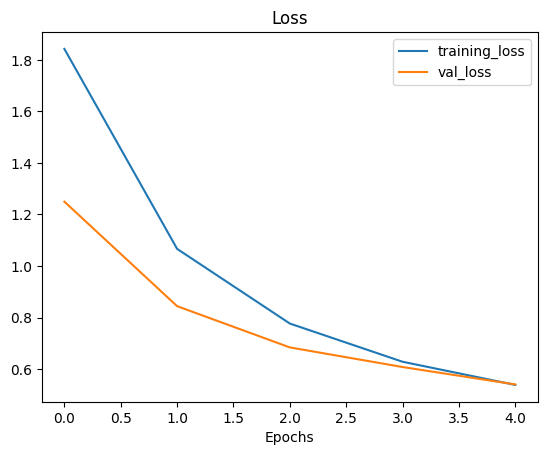

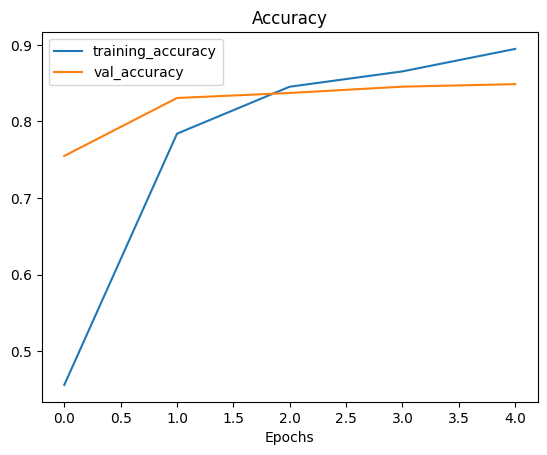

In [16]:
 # Check out our model's training curves
 plot_loss_curves(history_10_percent)

## Getting a feature vector from a traineed model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then it passes through GlobalAveragePooling2D, it turns into (none, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
Input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(Input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the ranodm tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooled Random Tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled tensor : {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Average Pooled Random Tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled tensor : (1, 3)


In [18]:
# Let's repicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data but how does it go with 1% of the training data... how about we set up bunch of experiment to find out:

1. `model_1` - use feature transfer learning with 1% of the training data with data augmentaion
2. `model_2` - use feature extraction transfer learning with 10% of the training data augmentation
3 `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% training data with data augmentation

> 🔑 **Note** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistancy across evaluation metrics.

## Getting and preprocessing data for model_1

In [19]:
# Download an unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-04-14 16:35:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  25.8MB/s    in 5.6s    

2023-04-14 16:35:46 (22.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#3 Adding data augmentation right into the model

To Add data augmentation right into the model we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

Benifits of using data augmentation inside the model :

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happes during training, so we can still export our whole model and usr it elsewhere

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficiemtMet's having rescaling built-in
], name="data_augmentation")

## Visualize our data augmentation layer (and see what happens to our data)

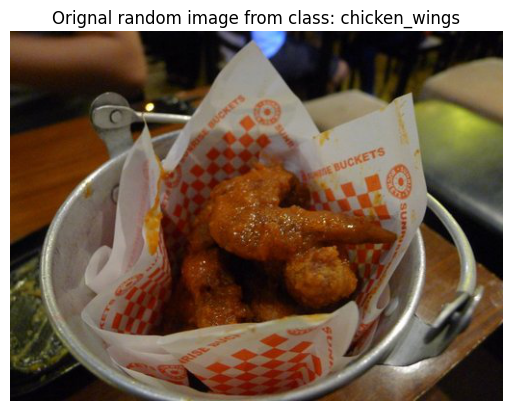

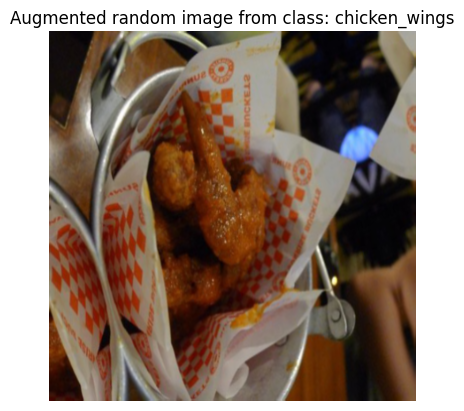

In [24]:
# View a random image and compare it to it's augmentaed version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)

plt.imshow(img)
plt.title(f"Orignal random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layers
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output feature on the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230414-163553
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3060 - accuracy: 0.1429 - val_loss: 2.1424 - val_accuracy: 0.2599
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0473 - accuracy: 0.3714 - val_loss: 2.0017 - val_accuracy: 0.3454
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8557 - accuracy: 0.5143 - val_loss: 1.8959 - val_accuracy: 0.4194
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6254 - accuracy: 0.6429 - val_loss: 1.7876 - val_accuracy: 0.5099
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5631 - accuracy: 0.6429 - val_loss: 1.6994 - val_accuracy: 0.5543


In [26]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 73ms/step - loss: 1.7170 - accuracy: 0.5416


[1.7170122861862183, 0.5415999889373779]

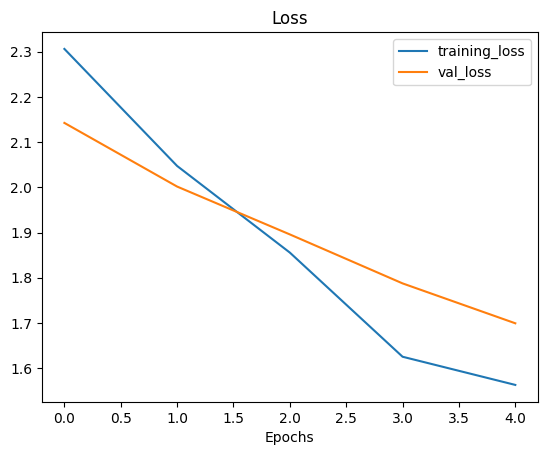

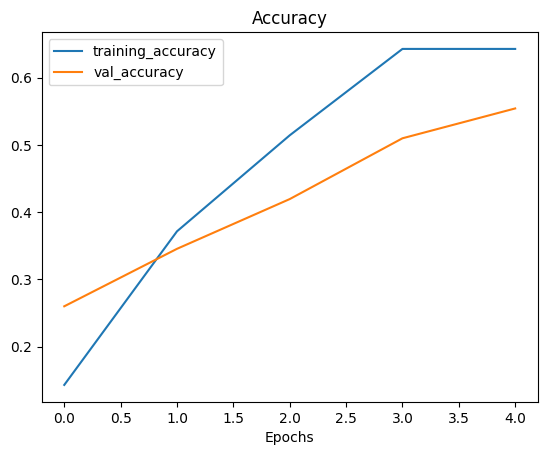

In [28]:
# How do the model with 1% of the data go with data augmentation looks
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction transfer learning model with 10% of the data and data augmentation

In [32]:
# Get 10% of data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-04-14 16:44:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  41.7MB/s    in 4.4s    

2023-04-14 16:44:41 (36.6 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [33]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [36]:
# How many images are ub direcotries
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [34]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_dir_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [38]:
# Create Model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import  preprocessing
from tensorflow.keras.models import Sequential

# Built data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficiemtMet's having rescaling built-in
], name="data_augmentation")

# Setup input shape to our model
imput_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input and outputs (including the layers in between)
input = layers.Input(shape=input_shape, name="input_shape")
x = data_augmentation(inputs) # augment our training images (augmentation does not occour on test data)
x = base_model(x, training=False) # Pass the augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina